## Importing the Libraries:

In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import pickle
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
from tqdm import tqdm
from tensorflow.keras import mixed_precision

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Data Analysis:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
with open('/content/drive/My Drive/train.csv', 'r') as f:
    train_df = pd.read_csv(f)
train_df
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8


In [6]:
train_df.nunique()

StudyInstanceUID              30083
ETT - Abnormal                    2
ETT - Borderline                  2
ETT - Normal                      2
NGT - Abnormal                    2
NGT - Borderline                  2
NGT - Incompletely Imaged         2
NGT - Normal                      2
CVC - Abnormal                    2
CVC - Borderline                  2
CVC - Normal                      2
Swan Ganz Catheter Present        2
PatientID                      3255
dtype: int64

In [7]:
train_df.shape
#13 - 2 = 11 labels which was also mentioned in the dataset description.
#That being said, there are two columns "StudyInstanceUID" and "PatientID" which do not hold valuable information. So, they can be dropped.

(30083, 13)

In [8]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
823952d6c      1
a27848a12      1
f98a26a73      1
58414b00a      1
85add7a56      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


<BarContainer object of 11 artists>

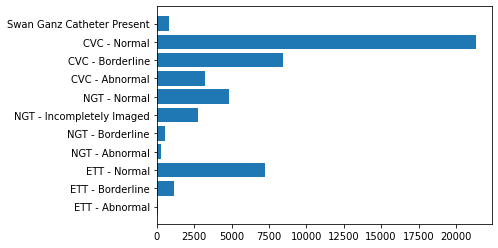

In [9]:
#plot label distrobution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
print(categoryCounts)
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])

#So according to the graph, most of the people had Normal condition in all three criteria "CVC", "NGT", and "ETT".

## Load the data:

In [10]:
!pwd

/content


In [11]:
# !pwd
os.chdir("./drive/My Drive/train/500_data")

In [12]:
#load x and y data
Xtrain = pickle.load(open("train.pickle", "rb"))
ytrain = pickle.load(open("target.pickle", "rb"))
pid = pickle.load(open("id.pickle", "rb"))

In [13]:
# Xtrain
Xtrain.shape #verified!

(500, 224, 224)

In [14]:
# ytrain
ytrain.shape

(500, 11)

In [15]:
# pid #is an array of arrays
pid.shape

(85,)

In [16]:
# train_df.iloc[[14, 29330], :] #verified!

## Scaling the data

In [17]:
#scale to 0-1

Xtrain_scaled = []
for pic in Xtrain:
    Xtrain_scaled.append(np.array(pic/255).astype(np.float32))
# Xtrain_scaled

In [18]:
len(Xtrain_scaled) #verified!

500

## Solving data leakage issue in features:

In [19]:
#since "pid" has repetitive elemetns, we should faltten it into variable "lst":
# All the pid items in a single list:

lst = []

for i in range(0, len(pid)):
    for j in range(0, len(pid[i])):
        lst.append(pid[i][j])
lst.sort()
lst = np.unique(lst)
# lst.shape

In [20]:
lst

array([  0,   2,  11,  16,  17,  21,  24,  25,  26,  29,  31,  32,  39,
        43,  49,  51,  53,  59,  61,  63,  65,  74,  75,  76,  79,  82,
        83,  96,  98, 100, 103, 109, 112, 114, 115, 116, 117, 121, 125,
       133, 137, 140, 145, 149, 151, 157, 158, 160, 161, 167, 168, 169,
       174, 176, 180, 183, 188, 190, 196, 202, 204, 208, 209, 210, 213,
       226, 227, 234, 235, 237, 242, 245, 253, 257, 258, 263, 268, 271,
       272, 276, 279, 281, 282, 286, 293, 294, 298, 299, 300, 306, 311,
       312, 319, 320, 321, 327, 330, 333, 336, 337, 343, 347, 348, 350,
       355, 360, 361, 362, 365, 366, 370, 372, 373, 387, 391, 398, 399,
       401, 408, 410, 414, 415, 416, 421, 422, 430, 433, 435, 437, 440,
       441, 444, 447, 448, 453, 458, 459, 461, 471, 475, 477, 478, 481,
       482, 488, 489, 492, 495, 499])

In [21]:
#repeteted list:

Xtrain_arr = np.array(Xtrain_scaled)
repeted_lst = []

for i in range(0, len(lst)):
    repeted_lst.append(Xtrain_arr[lst[i]])

repeted_lst = np.array(repeted_lst)
# repeted_lst.shape

In [22]:
#polished list:

Xtrain_polished = []

for i in range(0, len(Xtrain_arr)):
    if i in lst:
        pass
    else:
        Xtrain_polished.append(Xtrain_arr[i])

Xtrain_polished = np.array(Xtrain_polished)
# Xtrain_polished.shape

## Scaling the images:

In [23]:
#reshapeing the train images "Xtrain_scaled":

repeted_lst_scaled = repeted_lst.reshape((-1, 224, 224, 1))
Xtrain_polished_scaled = Xtrain_polished.reshape((-1, 224, 224, 1))

# repeted_lst_scaled.max() #verified
# Xtrain_polished_scaled.max() #verified

In [24]:
print(repeted_lst_scaled.shape) #verified
print(Xtrain_polished_scaled.shape) #verified

(149, 224, 224, 1)
(351, 224, 224, 1)


## Solving data leakage issue in labels:

In [25]:
#repeteted list:

repeted_y = ytrain[lst, :]
# repeted_y.shape

#..............#
#the four categories ETT, NGT, CVC, SG: 
repeted_ytrain_ETT = repeted_y[:, 0:3] #0, 1, 2
repeted_ytrain_NGT = repeted_y[:, 3:7] #3, 4, 5, 6
repeted_ytrain_CVC = repeted_y[:, 7:10]  #7, 8, 9
repeted_ytrain_sg = repeted_y[:, 10:11]  #10

In [26]:
#polished list:

polished_y = []

for i in range(0, len(ytrain)):
    if i in lst:
        pass
    else:
        polished_y.append(ytrain[i])
        
polished_y = np.array(polished_y)
# polished_y.shape

#..............#
#the four categories ETT, NGT, CVC, SG:
polished_ytrain_ETT = polished_y[:, 0:3] #0, 1, 2
polished_ytrain_NGT = polished_y[:, 3:7] #3, 4, 5, 6
polished_ytrain_CVC = polished_y[:, 7:10]  #7, 8, 9
polished_ytrain_sg = polished_y[:, 10:11]  #10

## Train-test split ETT: (requires a class of 3 in the output layer)

In [27]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_ETT, x_test_ETT, y_train_ETT, y_test_ETT = train_test_split(Xtrain_polished_scaled, polished_ytrain_ETT, test_size = 0.15, random_state = 0) #, shuffle = True

In [28]:
print(x_train_ETT.shape)
print(y_train_ETT.shape)
print(x_test_ETT.shape)
print(y_test_ETT.shape)

(298, 224, 224, 1)
(298, 3)
(53, 224, 224, 1)
(53, 3)


In [29]:
#Adding the repeted data to x_train:
x_train_added_ETT = np.array([])
x_train_added_ETT = np.append(x_train_ETT, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_ETT = np.array([])
y_train_added_ETT = np.append(y_train_ETT, repeted_ytrain_ETT, axis = 0)

In [30]:
print(x_train_added_ETT.shape) #verified!
print(y_train_added_ETT.shape) #verified!

(447, 224, 224, 1)
(447, 3)


## Train-test split NGT: (requires a class of 4 in the output layer)

In [31]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_NGT, x_test_NGT, y_train_NGT, y_test_NGT = train_test_split(Xtrain_polished_scaled, polished_ytrain_NGT, test_size = 0.15, random_state = 0) #, shuffle = True

In [32]:
print(x_train_NGT.shape)
print(y_train_NGT.shape)
print(x_test_NGT.shape)
print(y_test_NGT.shape)

(298, 224, 224, 1)
(298, 4)
(53, 224, 224, 1)
(53, 4)


In [33]:
#Adding the repeted data to x_train:
x_train_added_NGT = np.array([])
x_train_added_NGT = np.append(x_train_NGT, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_NGT = np.array([])
y_train_added_NGT = np.append(y_train_NGT, repeted_ytrain_NGT, axis = 0)

In [34]:
print(x_train_added_NGT.shape) #verified!
print(y_train_added_NGT.shape) #verified!

(447, 224, 224, 1)
(447, 4)


## Train-test split CVC: (requires a class of 3 in the output layer)

In [35]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_CVC, x_test_CVC, y_train_CVC, y_test_CVC = train_test_split(Xtrain_polished_scaled, polished_ytrain_CVC, test_size = 0.15, random_state = 0) #, shuffle = True

In [36]:
print(x_train_CVC.shape)
print(y_train_CVC.shape)
print(x_test_CVC.shape)
print(y_test_CVC.shape)

(298, 224, 224, 1)
(298, 3)
(53, 224, 224, 1)
(53, 3)


In [37]:
#Adding the repeted data to x_train:
x_train_added_CVC = np.array([])
x_train_added_CVC = np.append(x_train_CVC, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_CVC = np.array([])
y_train_added_CVC = np.append(y_train_CVC, repeted_ytrain_CVC, axis = 0)

In [38]:
print(x_train_added_CVC.shape) #verified!
print(y_train_added_CVC.shape) #verified!

(447, 224, 224, 1)
(447, 3)


## Train-test split SG: (requires a class of 1 in the output layer)

In [39]:
#split the data:
#Split using the scaled polished non-repetitive data "Xtrain_polished_scaled" + "polished_y" (-> "polished_ytrain_ETT", "polished_ytrain_NGT", "polished_ytrain_CVC", "polished_ytrain_sg")
#Then laster, add the scaled repetitive data "repeted_lst_scaled" + "repeted_y" (-> "repeted_ytrain_ETT", "repeted_ytrain_NGT", "repeted_ytrain_CVC", "repeted_ytrain_sg") to the train set (in order to tackle the leackage) 

x_train_SG, x_test_SG, y_train_SG, y_test_SG = train_test_split(Xtrain_polished_scaled, polished_ytrain_sg, test_size = 0.15, random_state = 0) #, shuffle = True

In [40]:
print(x_train_SG.shape)
print(y_train_SG.shape)
print(x_test_SG.shape)
print(y_test_SG.shape)

(298, 224, 224, 1)
(298, 1)
(53, 224, 224, 1)
(53, 1)


In [41]:
#Adding the repeted data to x_train:
x_train_added_SG = np.array([])
x_train_added_SG = np.append(x_train_SG, repeted_lst_scaled, axis = 0)


#Adding the repeted data to y_train:
y_train_added_SG = np.array([])
y_train_added_SG = np.append(y_train_SG, repeted_ytrain_sg, axis = 0)

In [42]:
print(x_train_added_SG.shape) #verified!
print(y_train_added_SG.shape) #verified!

(447, 224, 224, 1)
(447, 1)


## Model ETT: CNN 

In [ ]:
# build a sequential model

model_ETT = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_ETT.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_ETT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_ETT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_ETT.add(MaxPool2D(pool_size = (2, 2)))
model_ETT.add(BatchNormalization())
# ANN block
model_ETT.add(Flatten())
model_ETT.add(Dense(units = 128, activation = 'relu'))
model_ETT.add(Dense(units = 128, activation = 'relu'))
model_ETT.add(Dropout(0.5))
# output layer
model_ETT.add(Dense(units = 3, activation = 'softmax'))
 
# compile model
model_ETT.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_ETT.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_ETT.fit(x = x_train_added_ETT, y = y_train_added_ETT, epochs = 1000, batch_size = 32, validation_data = [x_test_ETT, y_test_ETT], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5274/5274 [==============================] - 5s 862us/sample - loss: 87025.3522 - accuracy: 0.2873 - val_loss: 4616.2044 - val_accuracy: 0.0949


In [ ]:
model_ETT.metrics_names

['loss', 'accuracy']

In [ ]:
metrics = pd.DataFrame(model_ETT.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3970.299396,0.283845,581.543796,0.094891
1,87025.352235,0.287258,4616.204380,0.094891


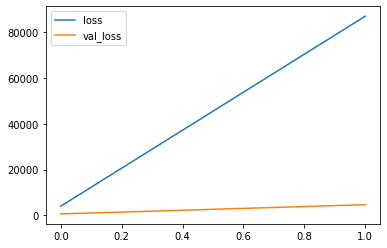

In [ ]:
metrics[['loss', 'val_loss']].plot()

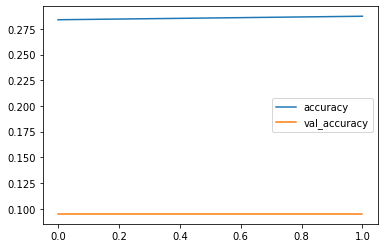

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_ETT.predict(x_test_ETT)
# confusion_matrix(y_test_ETT, y_pred)
# accuracy_score(y_test_ETT, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
x_test_ETT.shape

(137, 224, 224, 1)

In [ ]:
img_ex = x_test_ETT[0].reshape(224, 224)

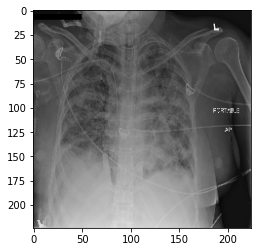

In [ ]:
plt.imshow(img_ex, cmap="gray")

In [ ]:
y_pred_ETT = model_ETT.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_ETT.astype(np.int32)

array([[0, 0, 1]], dtype=int32)

In [ ]:
y_pred_ETT.shape

(1, 3)

## Model NGT: CNN 

In [ ]:
# build a sequential model

model_NGT = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_NGT.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_NGT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_NGT.add(Conv2D(64, (3, 3), activation = 'relu'))
model_NGT.add(MaxPool2D(pool_size = (2, 2)))
model_NGT.add(BatchNormalization())
# ANN block
model_NGT.add(Flatten())
model_NGT.add(Dense(units = 128, activation = 'relu'))
model_NGT.add(Dense(units = 128, activation = 'relu'))
model_NGT.add(Dropout(0.5))
# output layer
model_NGT.add(Dense(units = 4, activation = 'softmax'))
 
# compile model
model_NGT.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_NGT.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_NGT.fit(x = x_train_added_NGT, y = y_train_added_NGT, epochs = 1000, batch_size = 32, validation_data = [x_test_NGT, y_test_NGT], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/1000
5274/5274 [==============================] - 8s 1ms/sample - loss: 73463.1492 - accuracy: 0.2114 - val_loss: 11488.2847 - val_accuracy: 0.0803


In [ ]:
model_NGT.metrics_names

['loss', 'accuracy']

In [ ]:
metrics = pd.DataFrame(model_NGT.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3903.985608,0.214638,1070.190237,0.080292
1,73463.149249,0.211414,11488.284686,0.080292


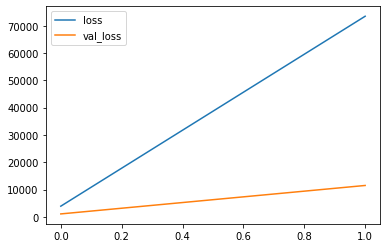

In [ ]:
metrics[['loss', 'val_loss']].plot()

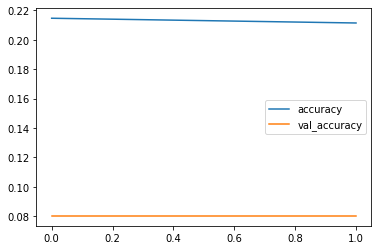

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_NGT.predict(x_test_NGT)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
x_test_NGT.shape

(137, 224, 224, 1)

In [ ]:
img_ex = x_test_NGT[0].reshape(224, 224)

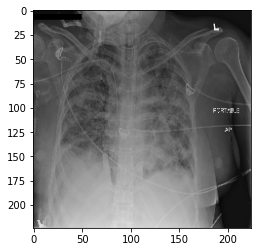

In [ ]:
plt.imshow(img_ex, cmap="gray")

In [ ]:
y_pred_NGT = model_NGT.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_NGT.astype(np.int32)

array([[0, 0, 0, 1]], dtype=int32)

In [ ]:
y_pred_NGT.shape

(1, 4)

## Model CVC: CNN 

In [ ]:
# build a sequential model

model_CVC = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_CVC.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_CVC.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_CVC.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC.add(MaxPool2D(pool_size = (2, 2)))
model_CVC.add(BatchNormalization())
# ANN block
model_CVC.add(Flatten())
model_CVC.add(Dense(units = 128, activation = 'relu'))
model_CVC.add(Dense(units = 128, activation = 'relu'))
model_CVC.add(Dropout(0.5))
# output layer
model_CVC.add(Dense(units = 3, activation = 'softmax'))
 
# compile model
model_CVC.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_CVC.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_CVC.fit(x = x_train_added_CVC, y = y_train_added_CVC, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5274/5274 [==============================] - 8s 1ms/sample - loss: 20.4918 - accuracy: 0.5184 - val_loss: 117.0284 - val_accuracy: 0.5693
Epoch 2/1000
5274/5274 [==============================] - 8s 1ms/sample - loss: 1206.7003 - accuracy: 0.4729 - val_loss: 1745.2897 - val_accuracy: 0.5693


In [ ]:
model_CVC.metrics_names

['loss', 'accuracy']

In [ ]:
metrics = pd.DataFrame(model_CVC.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,20.491757,0.518392,117.028420,0.569343
1,1206.700313,0.472886,1745.289688,0.569343


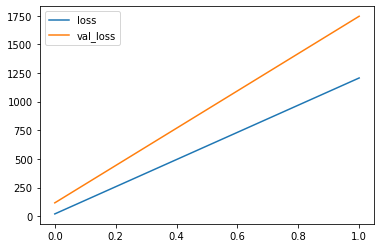

In [ ]:
metrics[['loss', 'val_loss']].plot()

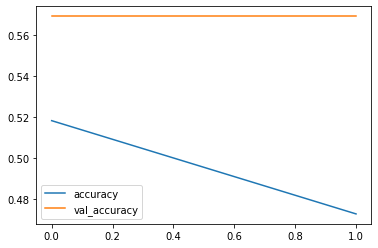

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_CVC.predict(x_test_CVC)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
x_test_CVC.shape

(137, 224, 224, 1)

In [ ]:
img_ex = x_test_CVC[0].reshape(224, 224)

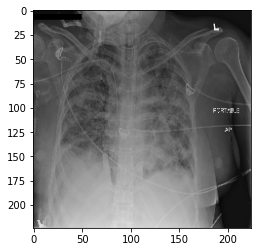

In [ ]:
plt.imshow(img_ex, cmap="gray")

In [ ]:
y_pred_CVC = model_CVC.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_CVC.astype(np.int32)

array([[0, 0, 1]], dtype=int32)

In [ ]:
y_pred_CVC.shape

(1, 3)

## Model SG: CNN 

In [ ]:
# build a sequential model

model_SG = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_SG.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_SG.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_SG.add(Conv2D(64, (3, 3), activation = 'relu'))
model_SG.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_SG.add(Conv2D(64, (3, 3), activation = 'relu'))
model_SG.add(MaxPool2D(pool_size = (2, 2)))
model_SG.add(BatchNormalization())
# ANN block
model_SG.add(Flatten())
model_SG.add(Dense(units = 128, activation = 'relu'))
model_SG.add(Dense(units = 128, activation = 'relu'))
model_SG.add(Dropout(0.5))
# output layer
model_SG.add(Dense(units = 1, activation = 'sigmoid'))
 
# compile model
model_SG.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_SG.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_SG.fit(x = x_train_added_SG, y = y_train_added_SG, epochs = 1000, batch_size = 32, validation_data = [x_test_SG, y_test_SG], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5274/5274 [==============================] - 8s 2ms/sample - loss: 0.1819 - accuracy: 0.9680 - val_loss: 0.1179 - val_accuracy: 0.9854
Epoch 2/1000
5274/5274 [==============================] - 7s 1ms/sample - loss: 0.1483 - accuracy: 0.9697 - val_loss: 0.0779 - val_accuracy: 0.9854
Epoch 3/1000
5274/5274 [==============================] - 7s 1ms/sample - loss: 0.1451 - accuracy: 0.9697 - val_loss: 0.1431 - val_accuracy: 0.9854


In [ ]:
model_SG.metrics_names

['loss', 'accuracy']

In [ ]:
metrics = pd.DataFrame(model_SG.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.181864,0.967956,0.117947,0.985401
1,0.148303,0.969662,0.077859,0.985401
2,0.145081,0.969662,0.143082,0.985401


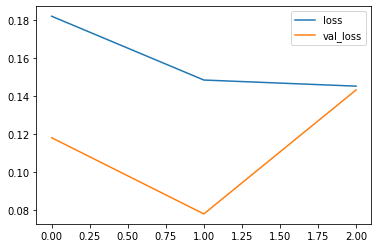

In [ ]:
metrics[['loss', 'val_loss']].plot()

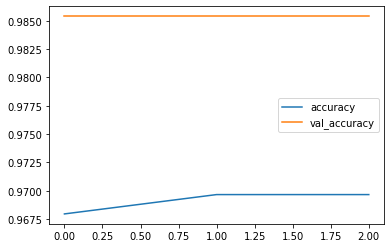

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_SG.predict(x_test_SG)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
x_test_SG.shape

(137, 224, 224, 1)

In [ ]:
img_ex = x_test_SG[0].reshape(224, 224)

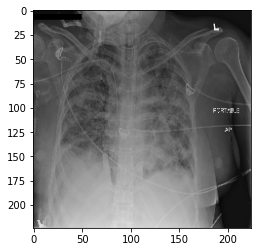

In [ ]:
plt.imshow(img_ex, cmap="gray")

In [ ]:
y_pred_SG = model_SG.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_SG.astype(np.int32)

array([[0]], dtype=int32)

In [ ]:
y_pred_SG.shape

(1, 1)

## Results:

In [ ]:
#Among all the diffrenet four catgories ETT, NGT, CVC, and SG the SG had the higheset accuracy.
#The reason could be that it is a binary classification; hence, demands less computations from the CNN model side.
#Another reason could be that the SG metric is quite clear and doesn't actually have particular hidden relationships to be discovered. 

## Train Model CVC-Abnormal:

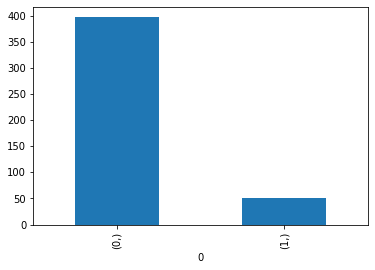

In [43]:
#So, CVC-Abnormal is highly imbalanced! -> Therefore, the "CVC-Abnormal" model will overfit quickly! 

pd.DataFrame(y_train_added_CVC[:, 0]).value_counts().plot(kind = 'bar') #imbalanced

In [44]:
!pwd

/content/drive/My Drive/train/500_data


##### The data:

In [45]:
#so far we had:

print(x_train_added_CVC.shape) #verified!
print(y_train_added_CVC.shape) #verified!
print(x_test_CVC.shape)
print(y_test_CVC.shape)

(447, 224, 224, 1)
(447, 3)
(53, 224, 224, 1)
(53, 3)


In [46]:
#We only need to change "y"s:

y_train_added_CVC_abnormal = y_train_added_CVC[:, 0]
y_test_CVC_abnormal = y_test_CVC[:, 0]

#### Model:

In [47]:
# build a sequential model

model_CVC_abnormal = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_CVC_abnormal.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_CVC_abnormal.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_CVC_abnormal.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_abnormal.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_CVC_abnormal.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_abnormal.add(MaxPool2D(pool_size = (2, 2)))
model_CVC_abnormal.add(BatchNormalization())
# ANN block
model_CVC_abnormal.add(Flatten())
model_CVC_abnormal.add(Dense(units = 128, activation = 'relu'))
model_CVC_abnormal.add(Dense(units = 128, activation = 'relu'))
model_CVC_abnormal.add(Dropout(0.5))
# output layer
model_CVC_abnormal.add(Dense(units = 1, activation = 'sigmoid'))
 
# compile model
model_CVC_abnormal.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_CVC_abnormal.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_CVC_abnormal.fit(x = x_train_added_CVC, y = y_train_added_CVC_abnormal, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC_abnormal], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


447/447 [==============================] - 34s 77ms/sample - loss: 0.5107 - accuracy: 0.7808 - val_loss: 0.4854 - val_accuracy: 0.9057
Epoch 2/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.4119 - accuracy: 0.8837 - val_loss: 0.6550 - val_accuracy: 0.9057


In [48]:
model_CVC_abnormal.metrics_names

['loss', 'accuracy']

In [49]:
metrics = pd.DataFrame(model_CVC_abnormal.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.510722,0.780761,0.485381,0.90566
1,0.411883,0.883669,0.654961,0.90566


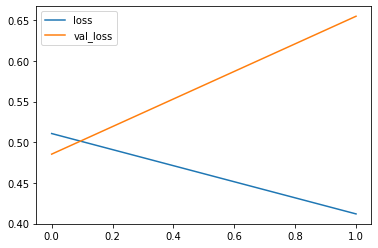

In [50]:
metrics[['loss', 'val_loss']].plot()

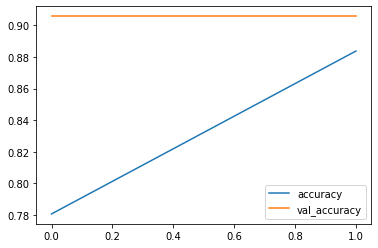

In [51]:
metrics[['accuracy', 'val_accuracy']].plot()

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_CVC_abnormal.predict(x_test_CVC)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [53]:
x_test_CVC.shape

(53, 224, 224, 1)

In [54]:
img_ex = x_test_CVC[0].reshape(224, 224) #img_ex -> x_test_CVC[0] -> y_test_CVC_abnormal[0]
y_pred_CVC = model_CVC_abnormal.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_CVC.astype(np.int32)

array([[0]], dtype=int32)

In [55]:
y_test_CVC_abnormal[0] #Same results!

0

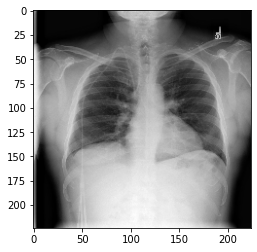

In [56]:
plt.imshow(img_ex, cmap="gray")

## Train Model CVC-Borderline:

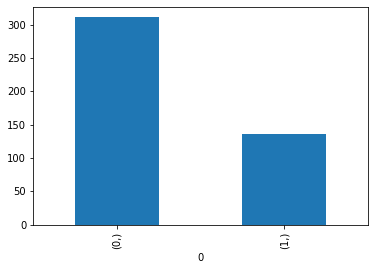

In [57]:
#So, CVC-Borderline is highly imbalanced! -> Therefore, the "CVC-Borderline" model will overfit quickly! 

pd.DataFrame(y_train_added_CVC[:, 1]).value_counts().plot(kind = 'bar') #imbalanced

##### The data:

In [58]:
#so far we had:

print(x_train_added_CVC.shape) #verified!
print(y_train_added_CVC.shape) #verified!
print(x_test_CVC.shape)
print(y_test_CVC.shape)

(447, 224, 224, 1)
(447, 3)
(53, 224, 224, 1)
(53, 3)


In [59]:
#We only need to change "y"s:

y_train_added_CVC_borderline = y_train_added_CVC[:, 1]
y_test_CVC_borderline = y_test_CVC[:, 1]

##### Model:

In [60]:
# build a sequential model

model_CVC_borderline = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_CVC_borderline.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_CVC_borderline.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_CVC_borderline.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_borderline.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_CVC_borderline.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_borderline.add(MaxPool2D(pool_size = (2, 2)))
model_CVC_borderline.add(BatchNormalization())
# ANN block
model_CVC_borderline.add(Flatten())
model_CVC_borderline.add(Dense(units = 128, activation = 'relu'))
model_CVC_borderline.add(Dense(units = 128, activation = 'relu'))
model_CVC_borderline.add(Dropout(0.5))
# output layer
model_CVC_borderline.add(Dense(units = 1, activation = 'sigmoid'))
 
# compile model
model_CVC_borderline.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_CVC_borderline.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_CVC_borderline.fit(x = x_train_added_CVC, y = y_train_added_CVC_borderline, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC_borderline], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


447/447 [==============================] - 1s 1ms/sample - loss: 0.6131 - accuracy: 0.6756 - val_loss: 0.6131 - val_accuracy: 0.8491
Epoch 3/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.5853 - accuracy: 0.6779 - val_loss: 0.6098 - val_accuracy: 0.8491
Epoch 4/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.5845 - accuracy: 0.6846 - val_loss: 0.5625 - val_accuracy: 0.8491
Epoch 5/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.5087 - accuracy: 0.7360 - val_loss: 0.5123 - val_accuracy: 0.8491
Epoch 6/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.4792 - accuracy: 0.7696 - val_loss: 0.6197 - val_accuracy: 0.8491


In [61]:
model_CVC_borderline.metrics_names

['loss', 'accuracy']

In [62]:
metrics = pd.DataFrame(model_CVC_borderline.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.804708,0.604027,0.716188,0.150943
1,0.613069,0.675615,0.613135,0.849057
2,0.585316,0.677852,0.609788,0.849057
3,0.584508,0.684564,0.562466,0.849057
4,0.508652,0.736018,0.512336,0.849057
5,0.479170,0.769575,0.619672,0.849057


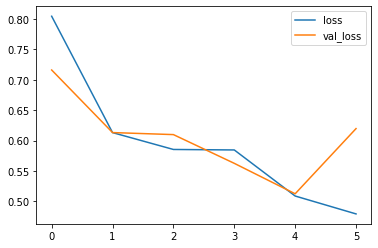

In [63]:
metrics[['loss', 'val_loss']].plot()

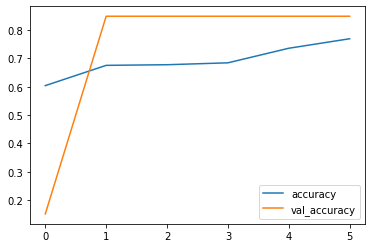

In [64]:
metrics[['accuracy', 'val_accuracy']].plot()

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_CVC_borderline.predict(x_test_CVC)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [66]:
x_test_CVC.shape

(53, 224, 224, 1)

In [67]:
img_ex = x_test_CVC[0].reshape(224, 224) #img_ex -> x_test_CVC[0] -> y_test_CVC_borderline[0]
y_pred_CVC = model_CVC_borderline.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_CVC.astype(np.int32)

array([[0]], dtype=int32)

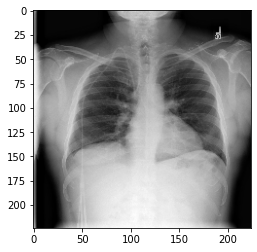

In [68]:
plt.imshow(img_ex, cmap="gray")

In [69]:
y_test_CVC_abnormal[0] #Same results!

0

## Train Model CVC-Normal:

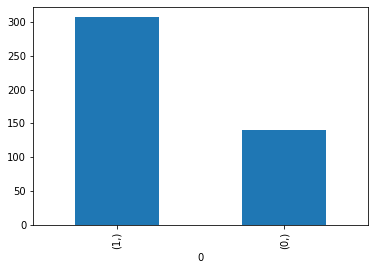

In [70]:
#So, CVC-Normal is highly imbalanced! -> Therefore, the "CVC-Normal" model will overfit quickly! 
#But compared to the CVC-Abnormal and CVC-Borderline, this is a bit better since it is less imbalanced.

pd.DataFrame(y_train_added_CVC[:, 2]).value_counts().plot(kind = 'bar') #imbalanced

In [71]:
#so far we had:

print(x_train_added_CVC.shape) #verified!
print(y_train_added_CVC.shape) #verified!
print(x_test_CVC.shape)
print(y_test_CVC.shape)

(447, 224, 224, 1)
(447, 3)
(53, 224, 224, 1)
(53, 3)


In [72]:
#We only need to change "y"s:

y_train_added_CVC_normal = y_train_added_CVC[:, 2]
y_test_CVC_normal = y_test_CVC[:, 2]

##### Model:

In [73]:
# build a sequential model

model_CVC_normal = Sequential()
# model.add(InputLayer(input_shape = (650, 650, 1), batch_size = 32))

# 1st conv block
model_CVC_normal.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
# 2nd conv block
model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
# 3rd conv block
model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
model_CVC_normal.add(BatchNormalization())
# ANN block
model_CVC_normal.add(Flatten())
model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
model_CVC_normal.add(Dropout(0.5))
# output layer
model_CVC_normal.add(Dense(units = 1, activation = 'sigmoid'))
 
# compile model
model_CVC_normal.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy']) #categorical_crossentropy

model_CVC_normal.summary()

#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)


# model.fit(x = Xtrain_scaled, y = ytrain, epochs = 1000, batch_size = 32, validation_split = 0.2) #callbacks = [early_stop])
model_CVC_normal.fit(x = x_train_added_CVC, y = y_train_added_CVC_normal, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC_normal], callbacks = [early_stop]) #callbacks = [early_stop])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


447/447 [==============================] - 1s 1ms/sample - loss: 0.6440 - accuracy: 0.6711 - val_loss: 0.6423 - val_accuracy: 0.8113
Epoch 3/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6156 - accuracy: 0.6823 - val_loss: 0.6285 - val_accuracy: 0.8113
Epoch 4/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.5812 - accuracy: 0.6868 - val_loss: 0.6397 - val_accuracy: 0.8113


In [74]:
model_CVC_normal.metrics_names

['loss', 'accuracy']

In [75]:
metrics = pd.DataFrame(model_CVC_normal.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.874405,0.592841,0.654564,0.811321
1,0.644012,0.671141,0.642331,0.811321
2,0.615626,0.682327,0.628494,0.811321
3,0.581222,0.686801,0.639700,0.811321


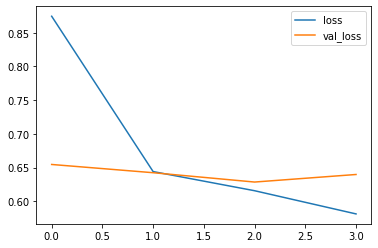

In [76]:
metrics[['loss', 'val_loss']].plot()

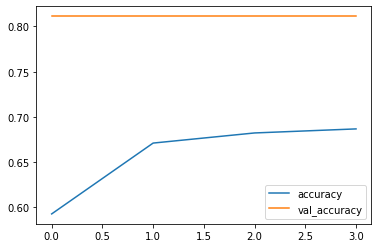

In [77]:
metrics[['accuracy', 'val_accuracy']].plot()

In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix

# predictions = model.predict_classes(x_test)
# print(classification_report(y_true = y_test, y_pred = predictions))
y_pred = model_CVC_normal.predict(x_test_CVC)
# confusion_matrix(y_test, y_pred)
# accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [79]:
img_ex = x_test_CVC[0].reshape(224, 224) #img_ex -> x_test_CVC[0] -> y_test_CVC_normal[0]
y_pred_CVC = model_CVC_borderline.predict(img_ex.reshape(1, 224, 224, 1))
y_pred_CVC.astype(np.int32)

array([[0]], dtype=int32)

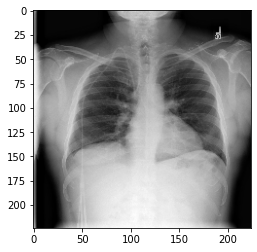

In [80]:
plt.imshow(img_ex, cmap="gray")

In [81]:
y_test_CVC_abnormal[0] #Same results!

0

## Results of the Three CVC Models:

In [82]:
#The model performance has significantly increased after using binary classification for each CVC label.

## Hyper-parameter Tunning:

### 1. Typical Hyper Parameter Tunning:
##### Learn more about at: <a href="https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594" target="_blank">Link</a>

In [83]:
#Hyper parameter Tunning is applied on the CVC-normal model:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

result_metrics = []
results_dic = []

opt_lst = [Adam, SGD, RMSprop]
lr_lst = [0.1, 0.01, 0.001]


for opt in opt_lst:
    for learning_rate in lr_lst:                
        model_CVC_normal = Sequential()
        model_CVC_normal.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
        model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
        model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
        model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
        model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
        model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
        model_CVC_normal.add(BatchNormalization())
        model_CVC_normal.add(Flatten())
        model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
        model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
        model_CVC_normal.add(Dropout(0.5))
        model_CVC_normal.add(Dense(units = 1, activation = 'sigmoid'))
        
        optimizer = opt(lr = learning_rate)
        model_CVC_normal.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

        model_CVC_normal.fit(x = x_train_added_CVC, y = y_train_added_CVC_normal, epochs = 1000, batch_size = 32, validation_data = [x_test_CVC, y_test_CVC_normal], callbacks = [early_stop])

        metrics = pd.DataFrame(model_CVC_normal.history.history)
        result_metrics.append(metrics)
        
        dic = dict({'optimizer':opt, 'learninng rate':learning_rate, 'accuracy':metrics['accuracy'].iloc[-2], 'validation accuracy':metrics['val_accuracy'].iloc[-2], 'loss':metrics['loss'].iloc[-2], 'validation loss':metrics['val_loss'].iloc[-2], 'metrics':metrics})
        results_dic.append(dic)

Train on 447 samples, validate on 53 samples
Epoch 1/1000
447/447 [==============================] - 1s 2ms/sample - loss: 318.1508 - accuracy: 0.5660 - val_loss: 10462.3687 - val_accuracy: 0.8113
Epoch 2/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


447/447 [==============================] - 1s 1ms/sample - loss: 0.6398 - accuracy: 0.6868 - val_loss: 766.0399 - val_accuracy: 0.8113
Epoch 3/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6238 - accuracy: 0.6868 - val_loss: 339.3476 - val_accuracy: 0.8113
Epoch 4/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6221 - accuracy: 0.6868 - val_loss: 84.0208 - val_accuracy: 0.8113
Epoch 5/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6241 - accuracy: 0.6868 - val_loss: 9.6571 - val_accuracy: 0.8113
Epoch 6/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6246 - accuracy: 0.6868 - val_loss: 0.5086 - val_accuracy: 0.8113
Epoch 7/1000
447/447 [==============================] - 1s 1ms/sample - loss: 0.6207 - accuracy: 0.6868 - val_loss: 0.5287 - val_accuracy: 0.8113
Train on 447 samples, validate on 53 samples
Epoch 1/1000
447/447 [==============================] - 1s 2ms/sample - loss: 5.7933 - 

In [84]:
max_acc_train = 0
itr_tarin = 0
max_acc_valid = 0
itr_valid = 0

for i in range(0, len(results_dic)):    
    #finding the max training accuracy:
    if results_dic[i]['accuracy'] > max_acc_train:
        max_acc_train = results_dic[i]['accuracy']
        itr_tarin = i
    #finding the max validation accuracy:
    if results_dic[i]['validation accuracy'] > max_acc_valid:
        max_acc_valid = results_dic[i]['validation accuracy'] 
        itr_valid = i

print('The maximum training accuracy occurs in the model with optimizer ({0}), learning rate {1}, and equals: {2} ' .format(results_dic[itr_tarin]['optimizer'], results_dic[itr_tarin]['learninng rate'], max_acc_train))
print('also the test accuracy for that would be {0}' .format(results_dic[itr_tarin]['validation accuracy']))

print('The maximum test accuracy occurs in the model with optimizer ({0}), learning rate {1}, and equals: {2} ' .format(results_dic[itr_valid]['optimizer'], results_dic[itr_valid]['learninng rate'], max_acc_valid))
print('also the train accuracy for that would be {0}' .format(results_dic[itr_valid]['accuracy']))

The maximum training accuracy occurs in the model with optimizer (<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>), learning rate 0.001, and equals: 0.6979866027832031 
also the test accuracy for that would be 0.8113207817077637
The maximum test accuracy occurs in the model with optimizer (<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>), learning rate 0.1, and equals: 0.8113207817077637 
also the train accuracy for that would be 0.6868008971214294


##### Results:

In [86]:
#So in CVC-Normal:
#1. The max training accuracy occurs in model with "Adam" optimizer and learning_rate "0.001", and train_accuracy = 69.79% (also the test_accuracy = 81.13%)
#2.The max test accuracy occurs in model with "Adam" optimizer and learning rate "0.1", and test_accuracy = 81.13% (also the train_accuracy = 68.68%)


#All in all, both of these model have a similar test accuracy. But the first one has higher train accuracy.
#Therefore, the first model with "Adam" optimizer and "0.001" learning rate.

### 2. K-Fold Cross Validation on the best model found for CVC-Normal in part 1:

In [87]:
# using the best model found in the previous part:
def create_model():
    model_CVC_normal = Sequential()
    model_CVC_normal.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(BatchNormalization())
    model_CVC_normal.add(Flatten())
    model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
    model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
    model_CVC_normal.add(Dropout(0.5))
    model_CVC_normal.add(Dense(units = 1, activation = 'sigmoid'))
        
    optimizer = Adam(lr = 0.001)
    model_CVC_normal.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
    return model_CVC_normal

In [88]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=2, 
                                 batch_size=32, 
                                 verbose=0)

In [89]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = neural_network, X = x_train_added_CVC, y = y_train_added_CVC_normal, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy: 65.73 %
Standard Deviation: 11.41 %


##### Results:

In [90]:
#Using K-Fold Cross Validation technique, the average accuacry over 10 folds is: 65.73%
#And the standard deviation of the accuracies is: 11.41%
#(Clearly, the results for the 5411-image dataset are better than those of the 500-image dataset!!)

### 3. Grid Search for batch sizes on the best model found for CVC-Normal in part 1: 
##### Learn more about at: <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/" target="_blank">Link</a>

In [91]:
# using the best model found in the previous part:
def create_model():
    model_CVC_normal = Sequential()
    model_CVC_normal.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1))) #padding = 'same'     #or adding "input_shape" instead of defining a seperate "InputLayer" 
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(Conv2D(64, (3, 3), activation = 'relu'))
    model_CVC_normal.add(MaxPool2D(pool_size = (2, 2)))
    model_CVC_normal.add(BatchNormalization())
    model_CVC_normal.add(Flatten())
    model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
    model_CVC_normal.add(Dense(units = 128, activation = 'relu'))
    model_CVC_normal.add(Dropout(0.5))
    model_CVC_normal.add(Dense(units = 1, activation = 'sigmoid'))
        
    optimizer = Adam(lr = 0.001)
    model_CVC_normal.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
    return model_CVC_normal

In [92]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
neural_network = KerasClassifier(build_fn=create_model,
                                 verbose=0)

In [93]:
batch_size = [10, 32, 100]
epochs = [2, 5, 10]

In [94]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = neural_network, X = x_train_added_CVC, y = y_train_added_CVC_normal, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy: 59.30 %
Standard Deviation: 16.46 %


##### Results:

In [95]:
#Using the Grid Search technique, the best accuracy is: 59.30%
#Which is achieved through: 16.46%
#The accuracy has changed, so the batch_size and also the epochs is imortant.